In [1]:
# https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab

import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from mutspec.utils.annot import translator

In [2]:
mut_raw = pd.read_csv("../data/processed/mutations.csv")
mut_raw

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,Uterus,4.0,97.4400,2311,T,GTA,1,rRNA,RNR2,-1,-1,NaN,9749.0,NaN,0,G[T>C]A
7607,Uterus,4.0,20.5300,3417,C,CCA,1,CDS,ND1,111,3,CCC,11961.0,CCT,2,C[C>T]A
7608,Uterus,4.0,67.3200,5267,T,TTA,1,CDS,ND2,798,3,ATT,15661.0,ATC,1,T[T>C]A
7609,Uterus,4.0,4.7800,14775,T,CTA,1,CDS,CYTB,29,2,CTA,17954.0,CCA,0,C[T>C]A


In [3]:
mut_raw[mut_raw.TBSS.isna()]

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
19,Bladder,200.0,1.14,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
20,Bone/SoftTissue,5373.0,57.94,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
21,Breast,84.5,1.01,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
22,Lymphoid,30.0,1.43,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
23,Prostate,120.0,12.28,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,Skin,147.0,4.53,5773,G,GGT,-1,tRNA,TRNC,-1,-1,NaN,NaN,NaN,0,G[G>A]T
7519,Thyroid,4138.0,21.98,243,A,CAA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[A>T]A
7533,Thyroid,4138.0,19.44,16250,C,TCC,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,T[C>T]C
7571,Uterus,4.0,7.08,5754,G,GGC,0,NaN,NaN,-1,-1,NaN,NaN,NaN,0,G[G>A]C


In [4]:
cols = "Mut TurnOverDays tumor_var_freq TBSS".split()
mut = mut_raw.dropna(subset="TBSS").loc[:, cols]
mut["Mut"] = mut["Mut"].str.slice(2, 5)
for sbs_l in mut.Mut.unique():
    sbs_h = sbs_l.translate(translator)
    sbs_h_styled = sbs_h[0] + "h>" + sbs_h[-1] + "h"
    mut[f"Dummy{sbs_h_styled}"] = (mut["Mut"] == sbs_l).astype(np.int8)
mut.head()

,Mut,TurnOverDays,tumor_var_freq,TBSS,DummyAh>Gh,DummyCh>Th,DummyTh>Ch,DummyTh>Gh,DummyCh>Gh,DummyGh>Ah,DummyAh>Th,DummyGh>Th,DummyAh>Ch,DummyCh>Ah,DummyTh>Ah,DummyGh>Ch
0,T>C,200.0,38.7900,10487.0,1,0,0,0,0,0,0,0,0,0,0,0
1,T>C,360.0,21.0500,10487.0,1,0,0,0,0,0,0,0,0,0,0,0
2,T>C,200.0,10.1400,426.0,1,0,0,0,0,0,0,0,0,0,0,0
3,G>A,200.0,37.3900,3816.0,0,1,0,0,0,0,0,0,0,0,0,0
4,G>A,11.0,0.7013,3816.0,0,1,0,0,0,0,0,0,0,0,0,0


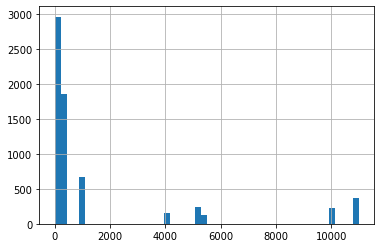

In [5]:
mut.TurnOverDays.hist(bins=50);

In [10]:
X = mut[cols[1:]]
X["DummyLowTurnOver"] = (X.TurnOverDays < 2000).astype(np.int8)
X["DummyMediumTurnOver"] = ((X.TurnOverDays > 2000) & (X.TurnOverDays < 6000)).astype(np.int8)
X["DummyHighTurnOver"] = (X.TurnOverDays > 6000).astype(np.int8)
X.drop("TurnOverDays", axis=1, inplace=True)
X.head()

,tumor_var_freq,TBSS,DummyLowTurnOver,DummyMediumTurnOver,DummyHighTurnOver
0,38.7900,10487.0,1,0,0
1,21.0500,10487.0,1,0,0
2,10.1400,426.0,1,0,0
3,37.3900,3816.0,1,0,0
4,0.7013,3816.0,1,0,0


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6595 entries, 0 to 7610
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tumor_var_freq       6595 non-null   float64
 1   TBSS                 6595 non-null   float64
 2   DummyLowTurnOver     6595 non-null   int8   
 3   DummyMediumTurnOver  6595 non-null   int8   
 4   DummyHighTurnOver    6595 non-null   int8   
dtypes: float64(2), int8(3)
memory usage: 173.9 KB


In [19]:
# ????????
_cols = "tumor_var_freq	TBSS".split()
scaler = StandardScaler()
scaled_fea = scaler.fit_transform(X[_cols])
X_scaled = X.copy()
X_scaled.loc[:, _cols] = scaled_fea
X_scaled

,tumor_var_freq,TBSS,DummyLowTurnOver,DummyMediumTurnOver,DummyHighTurnOver
0,0.725576,-0.094186,1,0,0
1,0.082337,-0.094186,1,0,0
2,-0.313252,-2.100632,1,0,0
3,0.674813,-1.424571,1,0,0
4,-0.655492,-1.424571,1,0,0
...,...,...,...,...,...
7606,2.852182,-0.241364,1,0,0
7607,0.063482,0.199771,1,0,0
7608,1.760053,0.937655,1,0,0
7609,-0.507602,1.394944,1,0,0


In [20]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X), family=sm.families.Binomial())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Fri, 22 Jul 2022   Deviance:                       7862.6
Time:                        20:16:15   Pearson chi2:                 6.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8131    

In [21]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X_scaled), family=sm.families.Binomial())
gamma_results = gamma_model.fit()
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Fri, 22 Jul 2022   Deviance:                       7862.6
Time:                        20:16:18   Pearson chi2:                 6.60e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.6700    